In [1]:
# import 

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST, TURTLE
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

In [2]:
# set style
import seaborn as sns

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [3]:
# tuples
end_year=2022
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]# five year periods
# make 5-year bins


# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')

In [5]:
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo



In [6]:
from rdflib import Graph


# finnish
f = Graph() 

f.parse('../../data/finnish_graph_new.nt')

# translated
g = Graph() 

g.parse('../../data/nat_lang_graph2.nt')

<Graph identifier=N0c29e4b19b7e408699156eb3a5982e23 (<class 'rdflib.graph.Graph'>)>

In [7]:
# genre

genre=pd.read_csv("../../data/genre_df.csv", sep="\t", index_col=0)
genre_dict={}
for i,v in genre.groupby("genrename").apply(lambda x: list(x["genre"])).iteritems():
   # print(i,v)
    #genre_dict[i]=" ".join(["<"+uri+">" for uri in v])
    genre_dict[i] =v

    
# cluster per genre information
# load genre graphs
g_fi = Graph() 
g_fi.parse("../../data/finnish_genre_theme.nt",format="nt")

g_fo = Graph() 
g_fo.parse("../data/translated_theme_genre_new.nt",format="nt")

<Graph identifier=Nadd7243d04454f9eb85bdf0aad6ad7d2 (<class 'rdflib.graph.Graph'>)>

In [31]:
g2 = Graph() 
g2.parse('/u/98/peurat1/unix/Desktop/kirjasampo/data/foreign_theme_genre.nt',format="nt")


<Graph identifier=N42a2979495f0475aa475e246ce5a668d (<class 'rdflib.graph.Graph'>)>

# genrekirjallisuus

In [32]:
# kaikki genret
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?genre (SAMPLE(?label) AS ?genrelabel)

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?year .
  #FILTER (?kieli !=  <http://lexvo.org/id/iso639-3/fin>  )
  
 ?teos rel:hasGenre ?genre. ?genre skos:prefLabel ?label .

  
} GROUP BY ?genre 

"""

qres = g2.query(Q)

In [33]:
genre=[{"genre":str(row.asdict()['genre'].toPython()), "genrelabel":str(row.asdict()['genrelabel'].toPython())}  for row in qres]
genre_dict ={str(row.asdict()['genre'].toPython()):str(row.asdict()['genrelabel'].toPython())  for row in qres}


In [35]:
# reverse
genre_dict_r={}
for key,v in genre_dict.items():
    if v in genre_dict_r.keys():
        print(v)
        old=genre_dict_r[v]
        genre_dict_r[v] = [old,key]
    else:
        genre_dict_r[v]=key

historiallinen jännityskirjallisuus
autofiktio


In [39]:
# halutut kategoriat
print(genre_dict_r["nuorten aikuisten kirjat"])
print(genre_dict_r["fantasiakirjallisuus"])
print(genre_dict_r["dystopiat"])
print(genre_dict_r["spekulatiivinen fiktio (kaunokirjallisuus)"])
print(genre_dict_r["uuskumma"])
print(genre_dict_r["klassikot"])
print(genre_dict_r["tieteiskirjallisuus"])

http://www.yso.fi/onto/koko/p50553
http://www.yso.fi/onto/koko/p12140
http://www.yso.fi/onto/koko/p51035
http://www.yso.fi/onto/koko/p73365
http://www.yso.fi/onto/koko/p74581
http://www.yso.fi/onto/koko/p36530
http://www.yso.fi/onto/koko/p13143


## fantasia

In [43]:
# käännetty
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?year (COUNT (DISTINCT ?teos) as ?novels)
WHERE

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?year .
  
  
 
 ?teos rel:hasGenre <http://www.yso.fi/onto/koko/p12140> .
 

FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?year

"""

qres = g2.query(Q)

In [44]:
for_fantasy=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]


tempdf=pd.DataFrame(for_fantasy)
tempdf["year"]=tempdf["year"].astype(int)
tempdf["count"]=tempdf["count"].astype(int)
tempdf.sort_values(by="year").tail()

,year,count
15,2016,45
24,2017,32
1,2018,30
7,2019,31
10,2020,36


In [46]:
# finnish

qres = g_fi.query(Q)
temp=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf_fi=pd.DataFrame(temp)
tempdf_fi["year"]=tempdf_fi["year"].astype(int)
tempdf_fi["count"]=tempdf_fi["count"].astype(int)
tempdf_fi.sort_values(by="year").tail()

,year,count
5,2016,31
8,2017,42
7,2018,48
0,2019,38
13,2020,43


In [47]:
years = list(range(1971,2021))
fantasy_df=pd.DataFrame(years)
fantasy_df.columns=["year"]
fantasy_df=fantasy_df.merge(tempdf, how="left")
fantasy_df=fantasy_df.merge(tempdf_fi,on="year", how="left", suffixes=["","_fi"])
fantasy_df=fantasy_df.fillna(0)

## scifi

In [50]:
# käännetty
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?year (COUNT (DISTINCT ?teos) as ?novels)
WHERE

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?year .
  
  
 
 ?teos rel:hasGenre <http://www.yso.fi/onto/koko/p13143> .
 

FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?year

"""

qres = g2.query(Q)
for_scifi=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]


tempdf=pd.DataFrame(for_scifi)
tempdf["year"]=tempdf["year"].astype(int)
tempdf["count"]=tempdf["count"].astype(int)
tempdf.sort_values(by="year").tail()

,year,count
10,2016,18
41,2017,15
24,2018,14
9,2019,21
7,2020,19


In [51]:
# finnish

qres = g_fi.query(Q)
temp=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf_fi=pd.DataFrame(temp)
tempdf_fi["year"]=tempdf_fi["year"].astype(int)
tempdf_fi["count"]=tempdf_fi["count"].astype(int)
tempdf_fi.sort_values(by="year").tail()

,year,count
21,2016,13
27,2017,13
29,2018,18
1,2019,18
5,2020,23


In [52]:
# df
years = list(range(1971,2021))
scifi_df=pd.DataFrame(years)
scifi_df.columns=["year"]
scifi_df=scifi_df.merge(tempdf, how="left")
scifi_df=scifi_df.merge(tempdf_fi,on="year", how="left", suffixes=["","_fi"])
scifi_df=scifi_df.fillna(0)

In [53]:
## ya

In [54]:
# käännetty
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?year (COUNT (DISTINCT ?teos) as ?novels)
WHERE

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?year .
  
  
 
 ?teos rel:hasGenre <http://www.yso.fi/onto/koko/p50553> .
 

FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?year

"""

qres = g.query(Q)

In [55]:
for_ya=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]


In [58]:
# finnish

qres = g_fi.query(Q)
temp=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]


In [59]:
tempdf_fi=pd.DataFrame(temp)
tempdf_fi["year"]=tempdf_fi["year"].astype(int)
tempdf_fi["count"]=tempdf_fi["count"].astype(int)
tempdf_fi.sort_values(by="year").tail()

,year,count
9,2016,15
20,2017,9
11,2018,16
2,2019,12
17,2020,14


In [60]:
years = list(range(1971,2021))
ya_df=pd.DataFrame(years)
ya_df.columns=["year"]
ya_df=ya_df.merge(tempdf, how="left")
ya_df=ya_df.merge(tempdf_fi,on="year", how="left", suffixes=["","_fi"])
ya_df=ya_df.fillna(0)

In [61]:
## dystopia

In [64]:
# käännetty
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?year (COUNT (DISTINCT ?teos) as ?novels)
WHERE

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?year .
  
  
 
 ?teos rel:hasGenre <http://www.yso.fi/onto/koko/p51035> .
 #?teos rel:hasGenre ?genre .
 #VALUES ?genre { <http://www.yso.fi/onto/koko/p73365> <http://www.yso.fi/onto/koko/p51035> }
 

FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?year

"""

qres = g2.query(Q)

In [65]:
for_dys=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf=pd.DataFrame(for_dys)
tempdf["year"]=tempdf["year"].astype(int)
tempdf["count"]=tempdf["count"].astype(int)
tempdf.sort_values(by="year").tail()

,year,count
0,2016,10
1,2017,6
8,2018,9
2,2019,10
3,2020,11


In [67]:
# finnish
qres = g_fi.query(Q)
temp=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf_fi=pd.DataFrame(temp)
tempdf_fi["year"]=tempdf_fi["year"].astype(int)
tempdf_fi["count"]=tempdf_fi["count"].astype(int)
tempdf_fi.sort_values(by="year").tail()

,year,count
16,2016,4
14,2017,7
5,2018,10
11,2019,6
4,2020,17


In [68]:
years = list(range(1971,2021))
dys_df=pd.DataFrame(years)
dys_df.columns=["year"]
dys_df=dys_df.merge(tempdf, how="left")
dys_df=dys_df.merge(tempdf_fi,on="year", how="left", suffixes=["","_fi"])
dys_df=dys_df.fillna(0)

## spekulatiivinen fiktio

In [72]:
# käännetty
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?year (COUNT (DISTINCT ?teos) as ?novels)
WHERE

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?year .
  
  
 
 ?teos rel:hasGenre <http://www.yso.fi/onto/koko/p73365> .
 #?teos rel:hasGenre ?genre .
 #VALUES ?genre { <http://www.yso.fi/onto/koko/p73365> <http://www.yso.fi/onto/koko/p51035> }
 

FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?year

"""

qres = g2.query(Q)

In [73]:
for_spek=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf=pd.DataFrame(for_spek)
tempdf["year"]=tempdf["year"].astype(int)
tempdf["count"]=tempdf["count"].astype(int)
tempdf.sort_values(by="year").tail()

,year,count
3,2016,2
0,2017,1
2,2018,2
1,2019,9
4,2020,2


In [77]:
# finnish
qres = g_fi.query(Q)
temp=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf_fi=pd.DataFrame(temp)
tempdf_fi["year"]=tempdf_fi["year"].astype(int)
tempdf_fi["count"]=tempdf_fi["count"].astype(int)
tempdf_fi.sort_values(by="year").tail()

,year,count
2,2016,2
5,2017,1
0,2018,9
3,2019,5
1,2020,9


In [78]:
years = list(range(1971,2021))
spek_df=pd.DataFrame(years)
spek_df.columns=["year"]
spek_df=spek_df.merge(tempdf, how="left")
spek_df=spek_df.merge(tempdf_fi,on="year", how="left", suffixes=["","_fi"])
spek_df=spek_df.fillna(0)

In [80]:
# käännetty
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?year (COUNT (DISTINCT ?teos) as ?novels)
WHERE

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?year .
  
  
 
 ?teos rel:hasGenre <http://www.yso.fi/onto/koko/p74581> .
 #?teos rel:hasGenre ?genre .
 #VALUES ?genre { <http://www.yso.fi/onto/koko/p73365> <http://www.yso.fi/onto/koko/p51035> }
 

FILTER(?year > 1970)
 FILTER(?year < 2021)
  
} GROUP BY ?year

"""

qres = g2.query(Q)

for_uus=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf=pd.DataFrame(for_uus)
tempdf["year"]=tempdf["year"].astype(int)
tempdf["count"]=tempdf["count"].astype(int)
tempdf.sort_values(by="year").tail()


# finnish
qres = g_fi.query(Q)
temp=[{"year":int(row.asdict()['year'].toPython()), "count":str(row.asdict()['novels'].toPython())}  for row in qres]

tempdf_fi=pd.DataFrame(temp)
tempdf_fi["year"]=tempdf_fi["year"].astype(int)
tempdf_fi["count"]=tempdf_fi["count"].astype(int)
tempdf_fi.sort_values(by="year").tail()


,year,count
2,2015,4
3,2016,1
1,2017,7
4,2019,1
0,2020,2


In [81]:
years = list(range(1971,2021))
uus_df=pd.DataFrame(years)
uus_df.columns=["year"]
uus_df=uus_df.merge(tempdf, how="left")
uus_df=uus_df.merge(tempdf_fi,on="year", how="left", suffixes=["","_fi"])
uus_df=uus_df.fillna(0)

## combine

In [83]:
combi=pd.concat([fantasy_df,ya_df,dys_df,spek_df,uus_df,scifi_df])
def rep(string, n):
    alist=[string]*n
    return alist
combi["cat"]=rep("fantasia",50)+ rep("YA",50)+rep("dystopia",50)+rep("spekulatiivinen fiktio",50)+rep("uuskumma",50)+rep("scifi",50)

In [84]:
# nan instead of zeros
combi["count"]=combi["count"].replace(0,np.nan)
combi["count_fi"]=combi["count_fi"].replace(0,np.nan)

In [85]:
combi=add_period(combi)

In [95]:
# translate
category_names={"fantasia":"fantasy", "dystopia":"dystopy",
                "spekulatiivinen fiktio":"speculative fiction","uuskumma":"new weird"}

#my_palette_2={"fantasia":sns.color_palette("Purples")[3],"dystopia":sns.color_palette("Blues")[1],"uuskumma":sns.color_palette("Blues")[4],"spekulatiivinen fiktio":sns.color_palette("Greens")[4],"YA":sns.color_palette("Reds")[3]}
#my_palette={"fantasia":sns.color_palette("PuOr")[5],"dystopia":sns.color_palette("PuOr")[0],"uuskumma":sns.color_palette("Blues")[5],"spekulatiivinen fiktio":sns.color_palette("Greens")[5],"YA":sns.color_palette("Reds")[4]}
my_palette={"fantasia":sns.color_palette("PuOr")[5],"scifi":sns.color_palette("Blues")[4],"dystopia":sns.color_palette("PuOr")[0],"uuskumma":sns.color_palette("Blues")[5],"spekulatiivinen fiktio":sns.color_palette("Greens")[5],"YA":sns.color_palette("Reds")[4]}

my_palette_2={"fantasia":sns.color_palette("Purples")[3],"scifi":sns.color_palette("Blues")[2],"dystopia":sns.color_palette("PuOr")[1],"uuskumma":sns.color_palette("Blues")[4],"spekulatiivinen fiktio":sns.color_palette("Greens")[4],"YA":sns.color_palette("Reds")[3]}


In [104]:
combi["period_new"]=combi["period"].apply(lambda x: str(x) + "-" +str(x+4))# new labels
#combi

In [106]:
combi_sub=combi[combi["cat"]!= "YA"].sort_values("period_new")
combi_sub

,year,count,count_fi,cat,period,period_new
0,1971,3.0,1.0,fantasia,1971,1971-1975
2,1973,9.0,2.0,scifi,1971,1971-1975
1,1972,4.0,4.0,scifi,1971,1971-1975
0,1971,2.0,NaN,scifi,1971,1971-1975
0,1971,NaN,NaN,dystopia,1971,1971-1975
...,...,...,...,...,...,...
45,2016,NaN,1.0,uuskumma,2016,2016-2020
46,2017,1.0,7.0,uuskumma,2016,2016-2020
47,2018,NaN,NaN,uuskumma,2016,2016-2020
49,2020,36.0,43.0,fantasia,2016,2016-2020


/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


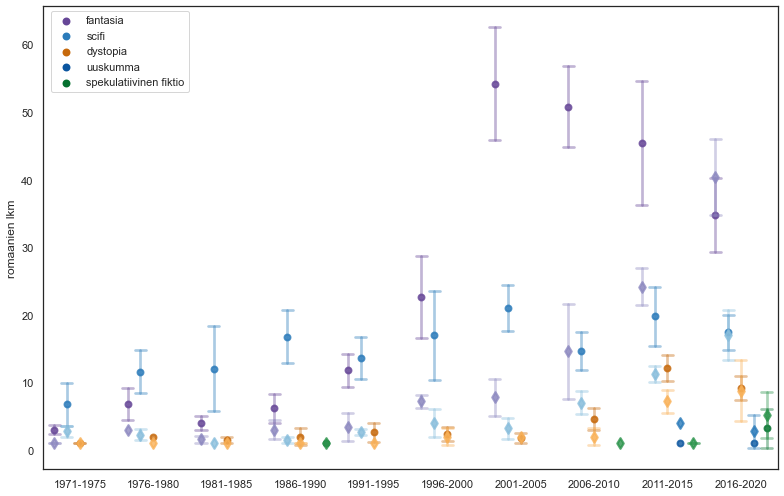

In [110]:
# plot the waves
fig,ax=plt.subplots(1, 1, figsize=(11,7))


p=sns.pointplot('period_new', 'count', hue='cat', alpha=0.7,
    data=combi_sub, dodge=0.7, join=False, ci='sd', markers="o",palette=my_palette, ax=ax, capsize=0.15, scale = 0.9)


sns.pointplot('period_new', 'count_fi', hue='cat', alpha=0.7,
    data=combi_sub, dodge=0.7, join=False, ci='sd', markers="d",palette=my_palette_2,ax=ax, capsize=0.15,scale = 1.1)
plt.setp(p.lines, alpha=.4)   


p.get_legend().remove()
# add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:5], labels[:5], bbox_to_anchor=(0.25, 0.98))#, loc='upper left', ncol=1, bbox_to_anchor=(1, 0.98))
ax.set_xticklabels(labels=ax.get_xticklabels(), ha="center")

ax.set(xlabel='', ylabel='romaanien lkm')
fig.tight_layout()
plt.setp(p.collections, alpha=.8) #for the markers
fig.savefig("../../output/fantasywaves.png")

In [111]:
# Some checks?

In [112]:
# don't waste time!